In [75]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.metrics import mean_absolute_error,mean_squared_error
import xgboost as xgb
import datetime
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

import joblib
import os
import tensorflow as tf

import warnings

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

In [47]:
data = yf.download("RELIANCE.NS", start="1990-01-01")

[*********************100%***********************]  1 of 1 completed


In [48]:
data=data[['Close']]

In [49]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

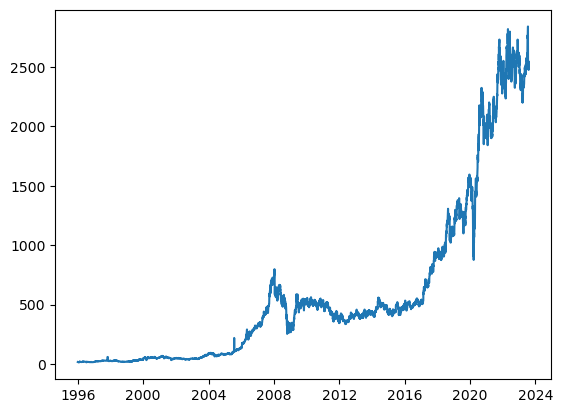

In [50]:
plt.plot(data.index, data['Close'])
plt.show()

In [51]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    
    target_date = first_date
    dates = []
    X, Y = [], []
    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
        target_date = next_date
        if target_date == last_date:
            last_time = True
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y
    
    return ret_df


In [52]:
windowed_df = df_to_windowed_df(data, 
                                '2021-03-23', 
                                '2023-08-03', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-23,2009.099976,2082.000000,2062.399902,2087.500000
1,2021-03-24,2082.000000,2062.399902,2087.500000,2047.300049
2,2021-03-25,2062.399902,2087.500000,2047.300049,1991.449951
3,2021-03-26,2087.500000,2047.300049,1991.449951,1994.650024
4,2021-03-30,2047.300049,1991.449951,1994.650024,2029.300049
...,...,...,...,...,...
582,2023-07-28,2485.800049,2526.199951,2502.699951,2527.850098
583,2023-07-31,2526.199951,2502.699951,2527.850098,2549.250000
584,2023-08-01,2502.699951,2527.850098,2549.250000,2513.199951
585,2023-08-02,2527.850098,2549.250000,2513.199951,2486.350098


In [53]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((587,), (587, 3, 1), (587,))

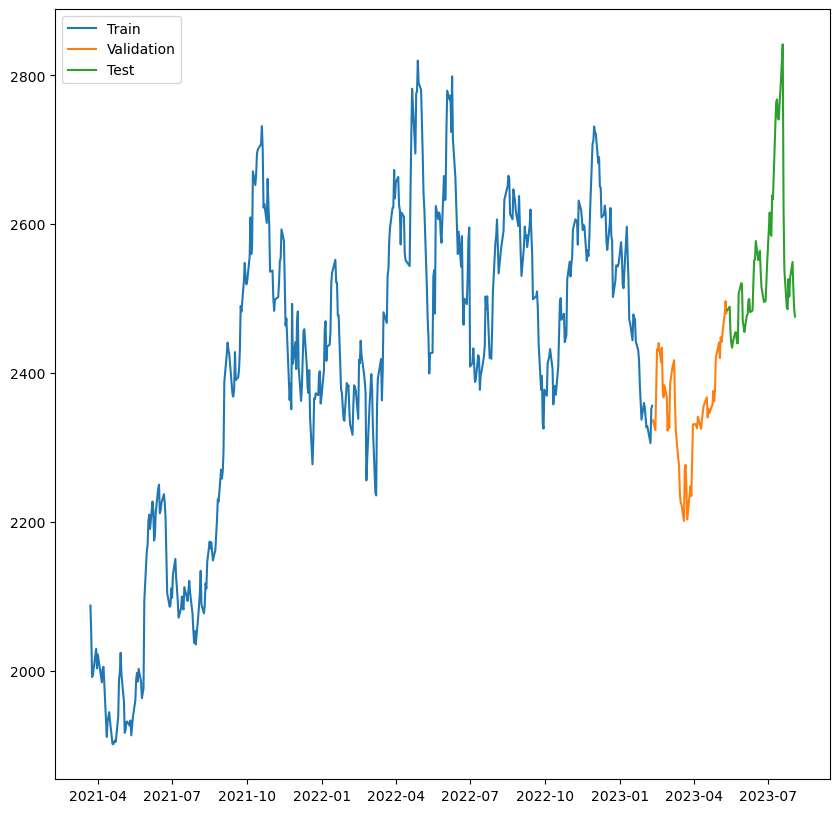

In [54]:
plt.figure(figsize=(10,10))
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(512),
                    layers.Dense(512, activation='relu'),
                    layers.Dense(512, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15/15 [==============================] - 3s 67ms/step - loss: 5730923.5000 - mean_absolute_error: 2384.0176 - val_loss: 5139905.0000 - val_mean_absolute_error: 2265.9580
Epoch 2/100
15/15 [==============================] - 1s 34ms/step - loss: 4775094.0000 - mean_absolute_error: 2171.6216 - val_loss: 3378294.5000 - val_mean_absolute_error: 1836.5598
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 2211966.5000 - mean_absolute_error: 1435.3073 - val_loss: 449661.1562 - val_mean_absolute_error: 666.5768
Epoch 4/100
15/15 [==============================] - 0s 28ms/step - loss: 195224.2188 - mean_absolute_error: 361.7754 - val_loss: 235654.9531 - val_mean_absolute_error: 479.9150
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 119128.5547 - mean_absolute_error: 270.5854 - val_loss: 5915.0254 - val_mean_absolute_error: 61.9285
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 59210.8906 - mean_absolute_er

Epoch 48/100
15/15 [==============================] - 0s 28ms/step - loss: 6073.0239 - mean_absolute_error: 58.4009 - val_loss: 3096.6650 - val_mean_absolute_error: 48.0185
Epoch 49/100
15/15 [==============================] - 0s 28ms/step - loss: 5628.9478 - mean_absolute_error: 58.5613 - val_loss: 1104.8824 - val_mean_absolute_error: 24.7828
Epoch 50/100
15/15 [==============================] - 0s 29ms/step - loss: 5026.1123 - mean_absolute_error: 52.7742 - val_loss: 2856.1414 - val_mean_absolute_error: 47.2020
Epoch 51/100
15/15 [==============================] - 0s 28ms/step - loss: 4886.1177 - mean_absolute_error: 52.7268 - val_loss: 1829.2589 - val_mean_absolute_error: 36.0457
Epoch 52/100
15/15 [==============================] - 0s 28ms/step - loss: 4433.1616 - mean_absolute_error: 50.3415 - val_loss: 3005.0652 - val_mean_absolute_error: 46.4685
Epoch 53/100
15/15 [==============================] - 0s 28ms/step - loss: 4747.5962 - mean_absolute_error: 53.8509 - val_loss: 4303.48

15/15 [==============================] - 0s 29ms/step - loss: 2147.3203 - mean_absolute_error: 36.4222 - val_loss: 1332.5306 - val_mean_absolute_error: 29.0792
Epoch 96/100
15/15 [==============================] - 1s 36ms/step - loss: 2732.1892 - mean_absolute_error: 41.9289 - val_loss: 1343.4396 - val_mean_absolute_error: 30.3630
Epoch 97/100
15/15 [==============================] - 0s 27ms/step - loss: 3208.5884 - mean_absolute_error: 45.7142 - val_loss: 1677.8236 - val_mean_absolute_error: 33.5705
Epoch 98/100
15/15 [==============================] - 0s 28ms/step - loss: 2447.5110 - mean_absolute_error: 38.0154 - val_loss: 1004.6680 - val_mean_absolute_error: 25.5756
Epoch 99/100
15/15 [==============================] - 0s 28ms/step - loss: 1817.1993 - mean_absolute_error: 32.5865 - val_loss: 1940.9137 - val_mean_absolute_error: 36.8748
Epoch 100/100
15/15 [==============================] - 0s 28ms/step - loss: 2148.3655 - mean_absolute_error: 35.6647 - val_loss: 1052.1786 - val_mea

15/15 [==============================] - 1s 8ms/step


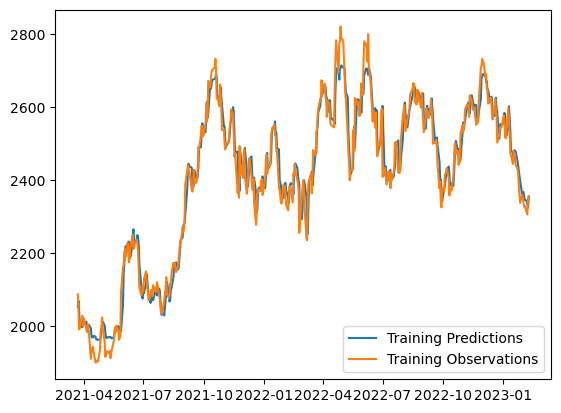

In [56]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 19ms/step


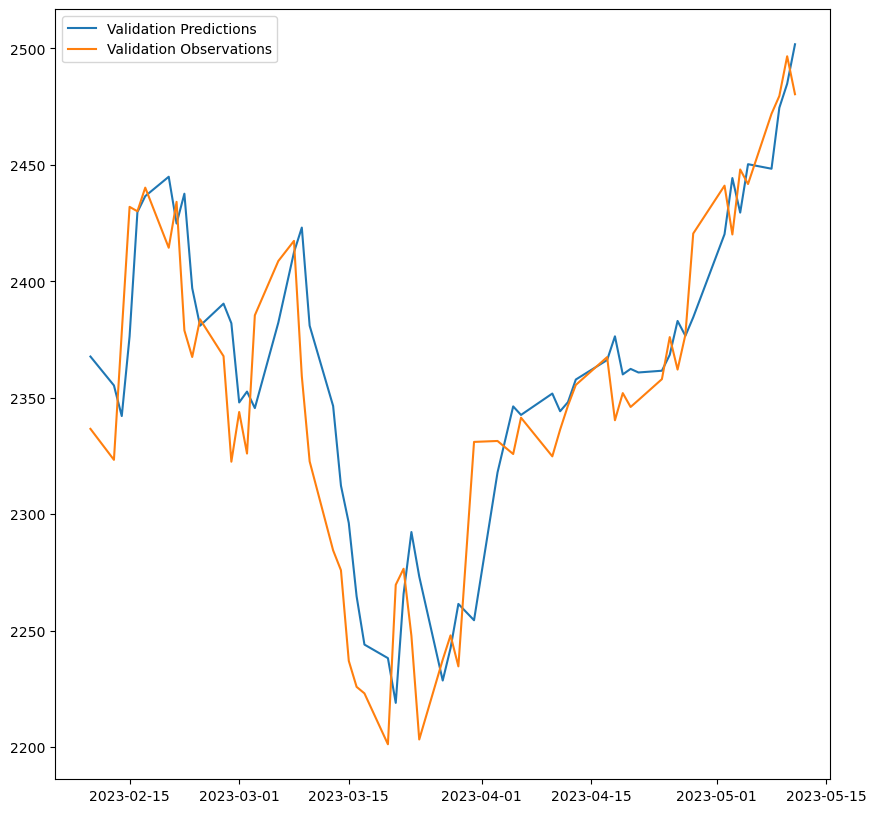

In [57]:
plt.figure(figsize=(10,10))
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 25ms/step


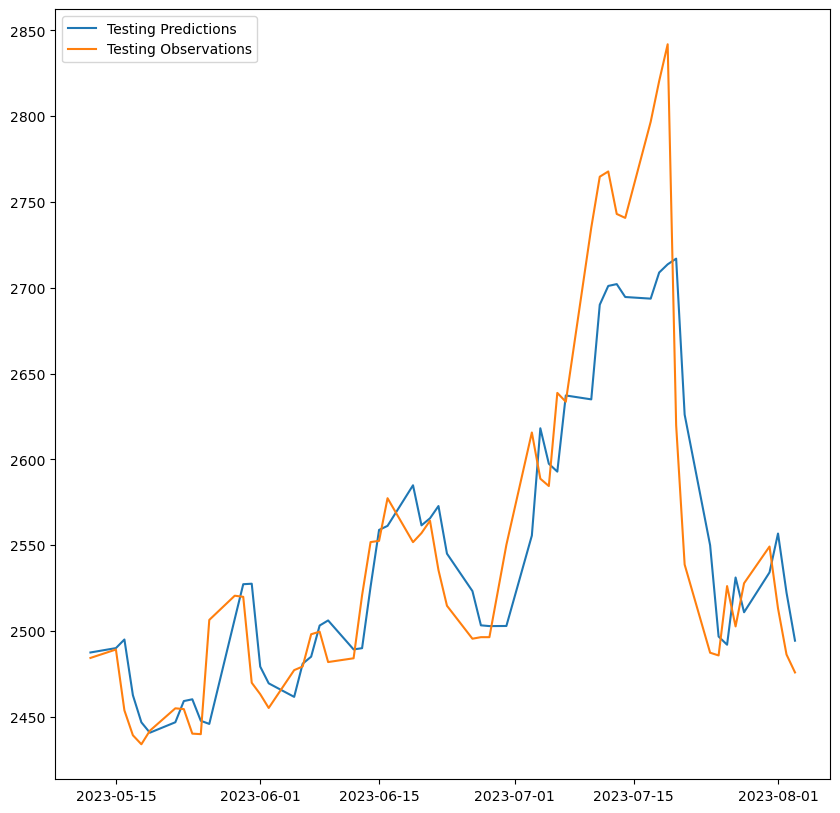

In [58]:
plt.figure(figsize=(10,10))
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [59]:
windowed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Target Date  587 non-null    datetime64[ns]
 1   Target-3     587 non-null    float64       
 2   Target-2     587 non-null    float64       
 3   Target-1     587 non-null    float64       
 4   Target       587 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 23.1 KB


In [60]:
windowed_df.index=windowed_df['Target Date']

In [65]:
windowed_df.sort_index(inplace=True,ascending=False)

In [68]:
train=windowed_df.loc['2021-01-23':'2023-07-03']
test=windowed_df.loc['2023-07-04':'2023-08-03']

In [70]:
X_train = train[['Target-3','Target-2','Target-1']]
y_train = train['Target']
X_test = test[['Target-3','Target-2','Target-1']]
y_test = test['Target']

In [71]:

class XGBoostRegressor:
    def __init__(self):
        self.seed=42
        self.model = xgb.XGBRegressor(random_state=self.seed)
        self.param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.01, 0.001],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        self.grid_search = GridSearchCV(estimator=self.model, param_grid=self.param_grid, cv=3)

    def fit(self, X_train, y_train):
        self.grid_search.fit(X_train, y_train)

    def predict(self, X_test):
        return self.grid_search.predict(X_test)

    def get_best_model(self):
        return self.grid_search.best_estimator_

In [73]:
xgb=XGBoostRegressor()
best_model=xgb.grid_search.fit(X_train,y_train)

In [77]:
y_pred=best_model.predict(X_test)
np.sqrt(mean_squared_error(y_pred,y_test))

52.0363124455591

In [ ]:
plt.figure(figsize=(10,10))
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])